In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import annoy
import h5py

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Print non-scientific 
np.set_printoptions(precision=4, suppress=True, formatter={'float': '{: 0.4f}'.format})
print("loaded libraries...")

loaded libraries...


In [2]:
f = h5py.File("s2s_fakedates/states.h5", "r")
states = f["decoder_out"]
states.shape

(20000, 50, 100)

## Load the data, compute targets and ignore padding

In [3]:
def assemble_training_data(data_ref):
    X = []
    Y = []
    ref_zeros = np.zeros(3)
    for ix, example in enumerate(data_ref):
        # First compute the length of the sequence
        max_len = example.shape[0]
        for word_ix, state in enumerate(example):
            if all(np.isclose(ref_zeros, state[0:3])):
                max_len = word_ix
                break
        for word_ix, state in enumerate(example[:max_len]):
            X.append(state)
            Y.append(word_ix/max_len)
        if ix % 500 == 0:
            print("Currently working on Iteration #{}.".format(ix))
        if ix > 2000:
            break
    return X, Y
%time X, Y = assemble_training_data(states)

Currently working on Iteration #0.
Currently working on Iteration #500.
Currently working on Iteration #1000.
Currently working on Iteration #1500.
Currently working on Iteration #2000.
CPU times: user 3.22 s, sys: 221 ms, total: 3.44 s
Wall time: 3.71 s


### Build Predictor

In [4]:
# prototype only
trainX = X[:]
trainY = Y[:]

In [5]:
# Not needed if we have a stored model
model = linear_model.LinearRegression()
%time model.fit(trainX, trainY)

CPU times: user 238 ms, sys: 32.6 ms, total: 270 ms
Wall time: 269 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [195]:
# model = linear_model.LinearRegression()
# with open("s2s_iwslt_ende/linear_progression_decoder.npz", 'rb') as fi:
#     coefs = np.load(fi)
# with open("s2s_iwslt_ende/linear_progression_decoder_intercept.npz", 'rb') as fi:
#     intercept = np.load(fi)
# model.coef_ = coefs
# model.intercept_ = intercept
model = joblib.load('s2s_iwslt_ende/linear_projection.pkl') 

In [6]:
# Make predictions using the training set
y_hat = model.predict(trainX)

In [7]:
# The coefficients
# print('Coefficients: \n', model.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(trainY, y_hat))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(trainY, y_hat))

Mean squared error: 0.00
Variance score: 0.96


In [29]:
# Save the coefficients to file
with open("s2s_iwslt_ende/linear_progression_decoder.npz", 'wb') as fi:
    np.save(fi, model.coef_)

In [28]:
with open("s2s_iwslt_ende/linear_progression_decoder_intercept.npz", 'wb') as fi:
    np.save(fi, model.intercept_)

In [8]:
from sklearn.externals import joblib
joblib.dump(model, 's2s_fakedates/linear_projection.pkl') 

['s2s_fakedates/linear_projection.pkl']

### Get progression for a series of states (not needed in prod)

In [9]:
def get_sent(ix, states):
    max_len = states[ix].shape[0]
    ref_zeros = np.zeros(3)
    for word_ix, state in enumerate(states[ix]):
        if all(np.isclose(ref_zeros, state[0:3])):
            max_len = word_ix
            break
    return states[ix][:max_len]
test_sent = get_sent(50, states)

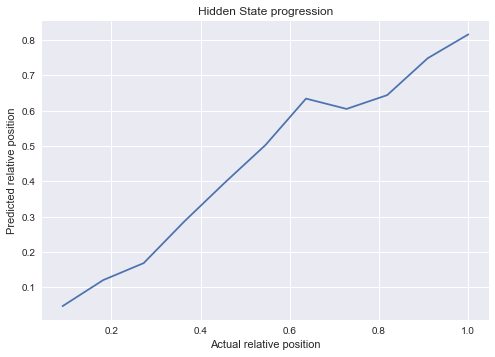

In [10]:
# Plot the progression
# test_ix = 150
test_ix = 333
test_sent = get_sent(test_ix, states)
y_vals = model.predict(test_sent)
word_prog = np.arange(1, test_sent.shape[0]+1,1)/(test_sent.shape[0])

plt.plot(word_prog, y_vals)
plt.title("Hidden State progression")
plt.xlabel("Actual relative position")
plt.ylabel("Predicted relative position")
plt.show()

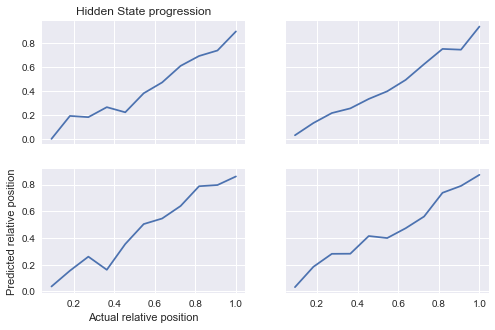

In [11]:
# Plot multiple for better comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8,5))
for ax, test_ix in zip([ax1, ax2, ax3, ax4], [50, 100, 150, 200]):
    test_sent = get_sent(test_ix, states)
    y_vals = model.predict(test_sent)
    word_prog = np.arange(1, test_sent.shape[0]+1,1)/(test_sent.shape[0])

    ax.plot(word_prog, y_vals)

ax1.set_title("Hidden State progression")

ax3.set_xlabel("Actual relative position")
ax3.set_ylabel("Predicted relative position")
plt.show()

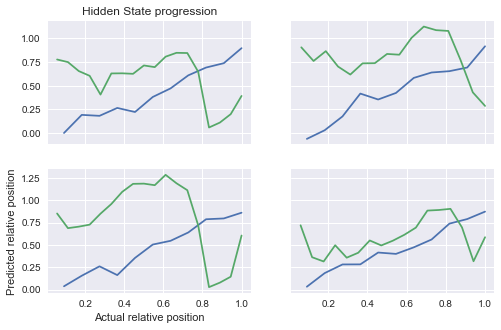

In [13]:
# Plot both encoder and decoder
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8,5))
for ax, test_ix in zip([ax1, ax2, ax3, ax4], [50, 105, 150, 200]):
    test_sent = get_sent(test_ix, states)
    y_vals = model.predict(test_sent)
    word_prog = np.arange(1, test_sent.shape[0]+1,1)/(test_sent.shape[0])
    ax.plot(word_prog, y_vals)
    
    test_sent_in = get_sent(test_ix, f["encoder_out"])
    y_vals = model.predict(test_sent_in)
    word_prog = np.arange(1, test_sent_in.shape[0]+1,1)/(test_sent_in.shape[0])
    
    ax.plot(word_prog, y_vals)
    

ax1.set_title("Hidden State progression")

ax3.set_xlabel("Actual relative position")
ax3.set_ylabel("Predicted relative position")
plt.show()

### Get second axis of the embedding - no subtracting component

In [171]:
# Good test sentences 234, 1337

In [14]:
from sklearn.manifold import TSNE

In [15]:
# Get a sentence for the TSNE
test_ix = 50
test_sent = get_sent(test_ix, states)
print("first sent:", test_sent.shape)
# Get a sentence we can compare to
test_ix2 = 100
test_sent2 = get_sent(test_ix2, states)
print("second sent:", test_sent2.shape)
# Combine the two for the T-SNE
v = np.concatenate((test_sent, test_sent2))
print("concat sent:", v.shape)

first sent: (11, 100)
second sent: (11, 100)
concat sent: (22, 100)


In [16]:
# Compute embedding for two sentences
y_coords = TSNE(n_components=1, init='pca').fit_transform(v)
# Compute the X coords with the progression model
x_coords = model.predict(v)

In [17]:
# Split into respective embeddings
testX_1 = x_coords[:test_sent.shape[0]]
testX_2 = x_coords[test_sent.shape[0]:]
testY_1 = y_coords[:test_sent.shape[0]]
testY_2 = y_coords[test_sent.shape[0]:]

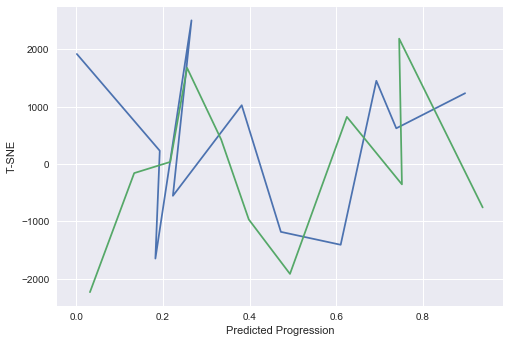

In [18]:
plt.plot(testX_1, testY_1)
plt.plot(testX_2, testY_2)
plt.xlabel("Predicted Progression")
plt.ylabel("T-SNE")
plt.show()

### With subtracting the component

In [19]:
# Get a sentence for the TSNE
test_ix = 50
test_sent = get_sent(test_ix, states)
print("first sent:", test_sent.shape)
# Get a sentence we can compare to
test_ix2 =  100
test_sent2 = get_sent(test_ix2, states)
print("second sent:", test_sent2.shape)
# Combine the two for the T-SNE
v = np.concatenate((test_sent, test_sent2))
print("concat sent:", v.shape)

first sent: (11, 100)
second sent: (11, 100)
concat sent: (22, 100)


In [20]:
# Compute the X coords with the progression model
x_coords = model.predict(v)

In [21]:
# For removing the coefficients
w = model.coef_
w = np.expand_dims(w, 1)
v_prime = v - np.dot(np.dot(v, w), w.T)
print("new v", v_prime.shape)

new v (22, 100)


In [22]:
# Compute embedding for two sentences
y_coords = TSNE(n_components=1, init='pca').fit_transform(v_prime)

In [23]:
# Split into respective embeddings
testX_1 = x_coords[:test_sent.shape[0]]
print("x1:", testX_1.shape)
testX_2 = x_coords[test_sent.shape[0]:]
print("x2:", testX_2.shape)
testY_1 = y_coords[:test_sent.shape[0]]
print("y1:", testY_1.shape)
testY_2 = y_coords[test_sent.shape[0]:]
print("y2:", testY_2.shape)

x1: (11,)
x2: (11,)
y1: (11, 1)
y2: (11, 1)


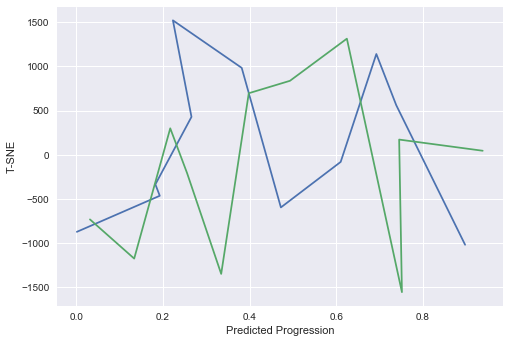

In [24]:
plt.plot(testX_1, testY_1)
plt.plot(testX_2, testY_2)
plt.xlabel("Predicted Progression")
plt.ylabel("T-SNE")
plt.show()

### For Hen: How to Use it

I'll show how to get the two projections below. 

In [25]:
# First, we load the model
model = joblib.load('s2s_fakedates/linear_projection.pkl') 

In [26]:
# Not needed for you - I get a test sentence
test_sent = get_sent(50, states)

### relative vs. predicted progression

In [27]:
# Quick wrapper around the classifier
def get_relative_progression(data, clf):
    return clf.predict(data)
# Test on the static data, result is one value per row of input
pred_progression = get_relative_progression(test_sent, model)
# Now we get the "real" progression
rel_progression = np.arange(1, test_sent.shape[0]+1,1)/(test_sent.shape[0])

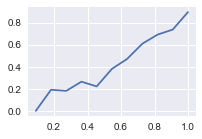

In [28]:
plt.figure(figsize = (3,2))
plt.plot(rel_progression, pred_progression)
plt.show()

### get the 1-d T-SNE with progression information removed

In [29]:
# Again not needed, but I want to compare two sentences here
test_sent2 = get_sent(100, states)
# I define our input "v" as the concatenation of all the states I want to investigate
v = np.concatenate((test_sent, test_sent2))

In [30]:
# Same as before, we predict the relative progression:
x_coords = get_relative_progression(v, model)

Now this part is a little weird. It is basically extracting all learned information from the progression model from the hidden states -> we don't want to show this in both axes. You can see the math [here](https://en.wikipedia.org/wiki/Principal_component_analysis):

$$ v^* = v - (v\cdot w) \cdot w^T$$

Here, $v$ is the input, and $w$ are the learned parameters for the length information

In [31]:
# For removing the coefficients
w = model.coef_
w = np.expand_dims(w, 1)
v_prime = v - np.dot(np.dot(v, w), w.T)

In [32]:
# We now do a TSNE on v_prime. init=pca makes it more stable
y_coords = TSNE(n_components=1, init='pca').fit_transform(v_prime)

In [34]:
# NOT needed for you, I want to split the sentences again
testX_1 = x_coords[:test_sent.shape[0]]
testX_2 = x_coords[test_sent.shape[0]:]
testY_1 = y_coords[:test_sent.shape[0]]
testY_2 = y_coords[test_sent.shape[0]:]

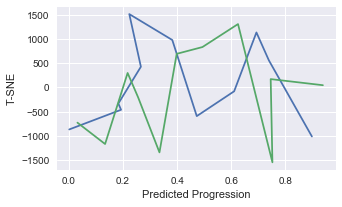

In [38]:
# and plot the whole thing
plt.figure(figsize=(5,3))
plt.plot(testX_1, testY_1)
plt.plot(testX_2, testY_2)
plt.xlabel("Predicted Progression")
plt.ylabel("T-SNE")
plt.show()